In [27]:
import pandas as pd
import numpy as np

import urllib
import html
import json
import re

import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer

from collections import Counter, defaultdict
from functools import lru_cache
from functools import reduce
import tqdm

In [ ]:
%matplotlib inline
pd.options.display.max_columns=100
pd.options.display.max_colwidth=100

nltk.download('punkt')

### дамп с Хакерньюз за май 2018 г. ссылка: https://files.pushshift.io/hackernews/

In [2]:
set_of_confs = []
type_count_dict = defaultdict(list)

with open('./data/HNI_2018-05', 'r') as f:
    for line in f:
        temp_dict = json.loads(line)
        set_of_confs.append(tuple(sorted(temp_dict.keys())))
        type_of_post = temp_dict['type']
        type_count_dict[type_of_post].append(tuple(sorted(temp_dict.keys())))     

### различные конфигурации постов

In [128]:
print('number of unique configurations = {} \n'.format(len(set(set_of_confs))))

print('count \t configuration')
for configuration, count in sorted(Counter(set_of_confs).items(), key=lambda x: x[1], reverse=True):
    print(count, '\t', configuration)

number of unique configurations = 33 

count 	 configuration
101325 	 ('by', 'id', 'parent', 'retrieved_on', 'text', 'time', 'type')
95565 	 ('by', 'id', 'kids', 'parent', 'retrieved_on', 'text', 'time', 'type')
17409 	 ('by', 'descendants', 'id', 'retrieved_on', 'score', 'time', 'title', 'type', 'url')
6528 	 ('by', 'dead', 'id', 'retrieved_on', 'score', 'time', 'title', 'type', 'url')
5152 	 ('by', 'descendants', 'id', 'kids', 'retrieved_on', 'score', 'time', 'title', 'type', 'url')
4952 	 ('deleted', 'id', 'parent', 'retrieved_on', 'time', 'type')
2430 	 ('by', 'dead', 'id', 'parent', 'retrieved_on', 'text', 'time', 'type')
858 	 ('by', 'descendants', 'id', 'kids', 'retrieved_on', 'score', 'text', 'time', 'title', 'type')
857 	 ('deleted', 'id', 'retrieved_on', 'time', 'type')
504 	 ('by', 'dead', 'id', 'kids', 'parent', 'retrieved_on', 'text', 'time', 'type')
452 	 ('by', 'descendants', 'id', 'retrieved_on', 'score', 'text', 'time', 'title', 'type')
384 	 ('by', 'dead', 'id', 'retr

In [18]:
columns = list(reduce(lambda x, y: set(x) | set(y), set_of_confs))
list_of_dfs = []

with open('./data/HNI_2018-05', 'r') as f:
    for line in tqdm.tqdm(f, total=len(set_of_confs)):
        temp_dict = json.loads(line)
        start_dict = {col: [None] for col in columns}
        for column_name, column_value in temp_dict.items():
            start_dict[column_name] = [column_value]
        list_of_dfs.append(pd.DataFrame(start_dict)) 
        
fin_df = pd.concat(list_of_dfs).reset_index(drop=True)
fin_df.to_csv('./data/df_hni_2018_05.csv', index=None)

100%|██████████| 237646/237646 [03:34<00:00, 1108.12it/s]


In [35]:
fin_df = pd.read_csv('./data/df_hni_2018_05.csv')

In [37]:
fin_df.head(2)

,by,dead,deleted,descendants,id,kids,parent,parts,poll,retrieved_on,score,text,time,title,type,url
0,burntwater,None,None,None,16963601,None,16962078,None,None,1528401048,None,"The New York State fee by itself is $200. Unless I&#x27;m missing something, you paid significan...",1525132803,None,comment,None
1,sswaner,None,None,None,16963602,[16964110],16962984,None,None,1528401048,None,Where in the article is the allegation or assertion of invention? Wittgenstein was focused on t...,1525132825,None,comment,None


In [30]:
fin_df.shape

(237646, 17)

### нулевые значения, корреляция и каунтплоты

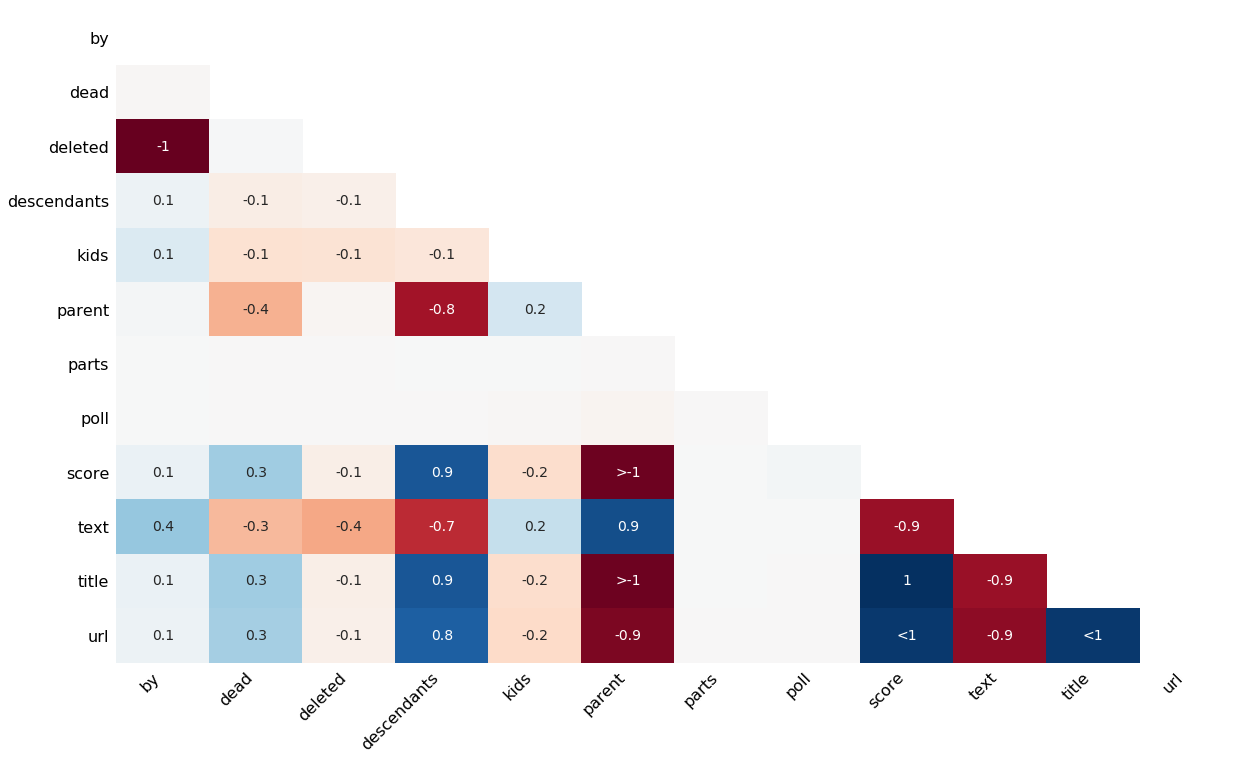

In [38]:
missingno.heatmap(fin_df)

 самые часто встречающиеся типы постов - комментарии и стори

In [42]:
fin_df['type'].value_counts()

comment    204974
story       32473
job           160
pollopt        36
poll            3
Name: type, dtype: int64

###  для стори характерны descedants (потомки) и дети, скор, титл и url

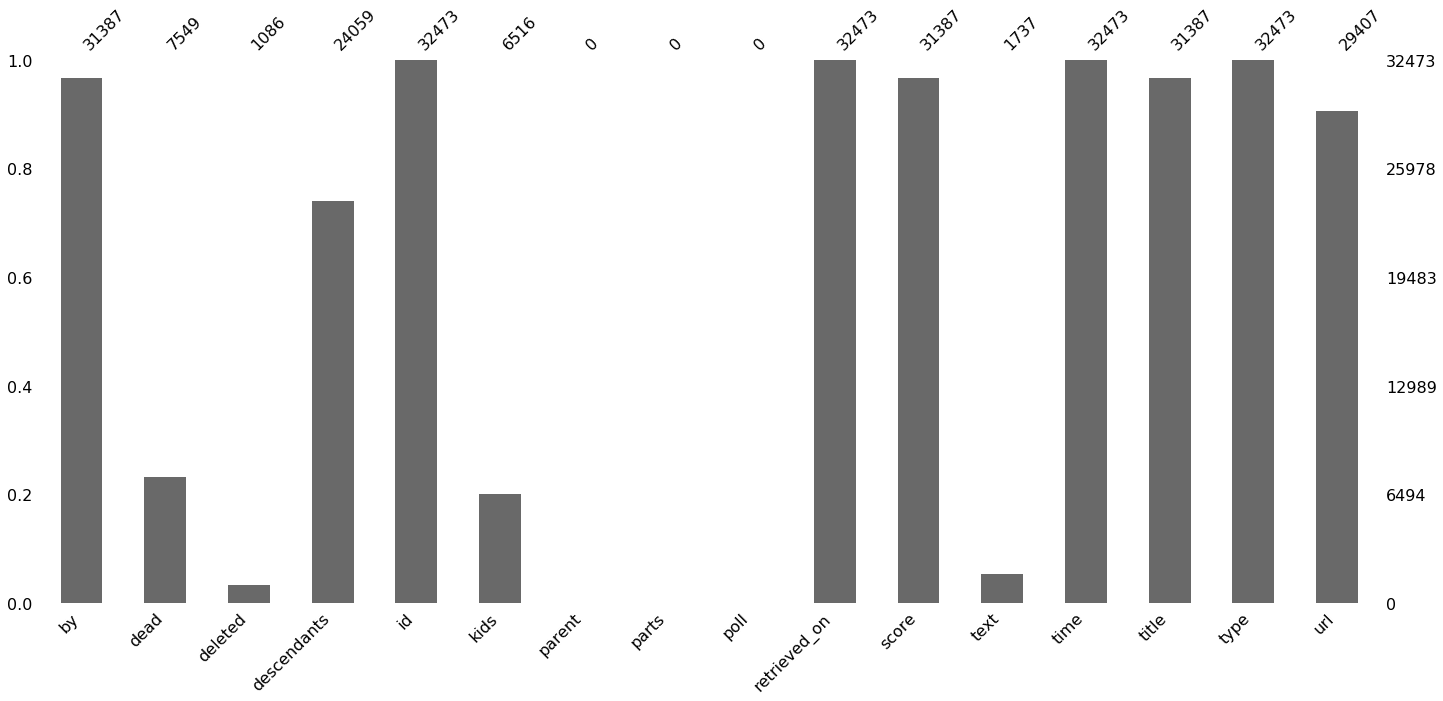

In [40]:
missingno.bar(fin_df[fin_df['type']=='story'])

### для комментариев характерны kids, parent и text

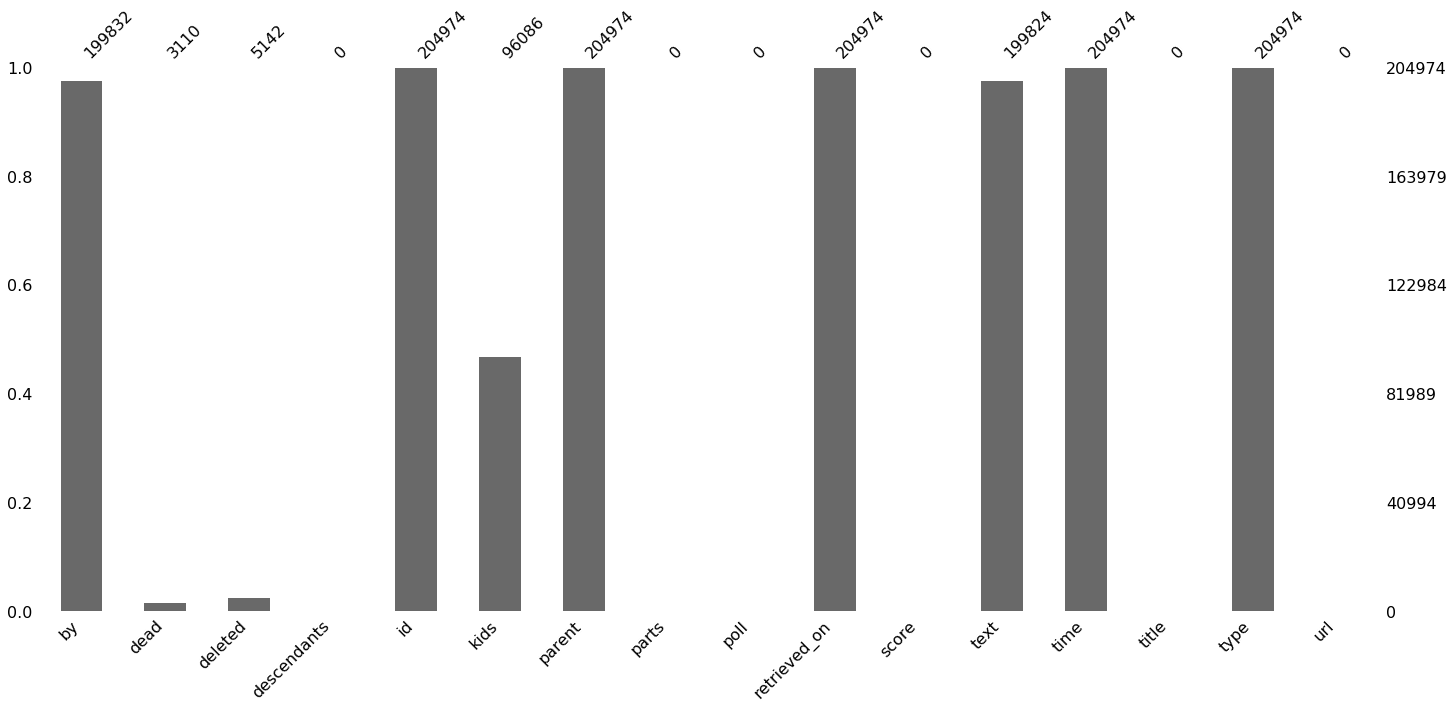

In [41]:
missingno.bar(fin_df[fin_df['type']=='comment'])

### для большинства данных мы знаем автора, id поста, время, связи с другими, какой-то текст 

### даты: 

в выходные дни количество стори и комментариев снижается вдвое

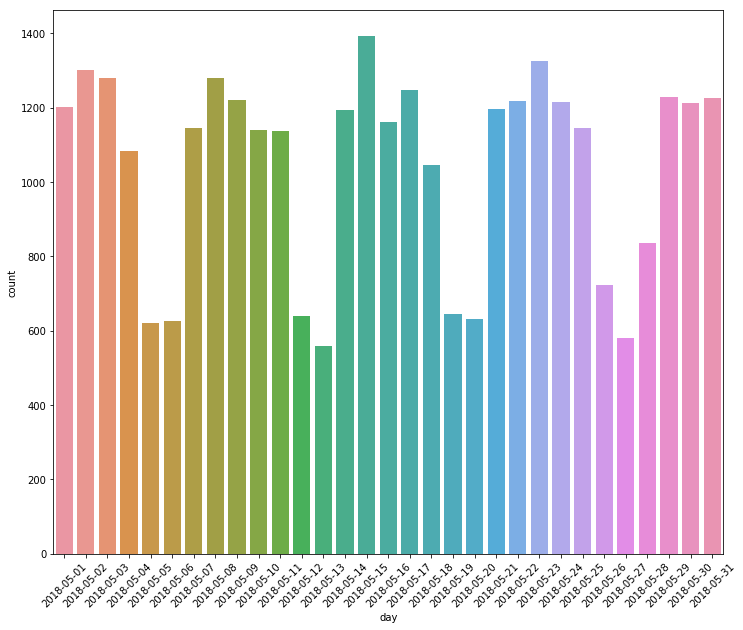

In [223]:
fin_df['day'] = pd.to_datetime(fin_df.time, unit='s').dt.date

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
sns.countplot(data=fin_df[fin_df['type']=='story'][['id', 'day']],x='day', order=sorted(fin_df.day.unique()))
plt.show()

дата извлечения всегда больше чем время, при этом уникальный пост извлекался только 1 раз

и разница во времени между извлечением и публикацией составляет от 7 до 37 дней, 
за такое непродолжительное время могли не собраться все комментарии и не устаканиться оценка

In [112]:
fin_df[['retrieved_on', 'time']].head(3)

,retrieved_on,time
0,1528401048,1525132803
1,1528401048,1525132825
2,1528401048,1525132827


In [111]:
fin_df['id'].value_counts().head(3)

16965540    1
17132280    1
16964366    1
Name: id, dtype: int64

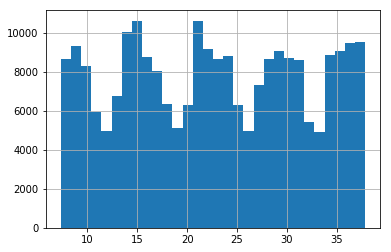

In [132]:
((fin_df['retrieved_on'] - fin_df['time'])/60/60/24).hist(bins=30)

### первичная статистика по текстам

In [48]:
fin_df.fillna('', subset=['text', 'title'], inplace=True)

fin_df.loc[:, 'text'] = fin_df.loc[:, 'text'].apply(html.unescape)
fin_df.loc[:, 'title'] = fin_df.loc[:, 'title'].apply(html.unescape)

In [51]:
fin_df['text_sentences'] = fin_df['text'].astype(str).apply(sent_tokenize)

tok = RegexpTokenizer(r'\w+')
fin_df['text_words'] = fin_df['text'].apply(tok.tokenize)
fin_df['title_words'] = fin_df['title'].apply(tok.tokenize)

In [52]:
fin_df['text_words_count'] = fin_df['text_words'].apply(lambda x: len(x))
fin_df['title_words_count'] = fin_df['title_words'].apply(lambda x: len(x))

In [53]:
fin_df['text_sentences_count'] = fin_df['text_sentences'].apply(lambda x: len(x))

In [54]:
fin_df['lengths_of_text_words'] = fin_df['text_words'].apply(lambda x: [len(w) for w in x])
fin_df['lengths_of_title_words'] = fin_df['title_words'].apply(lambda x: [len(w) for w in x])

### вопросы 

Надо ли для первоначальной аналитики чистить стоп слова и цифры?????


Например, у меня в бохплотах в длине слова считаются to and etc... 

а что делать с ин языками? надо их отдельно детектить, получается? 

In [61]:
fin_df[['text', 'text_sentences_count', 'text_words', 'text_words_count', 'lengths_of_text_words']].head(1)

,text,text_sentences_count,text_words,text_words_count,lengths_of_text_words
0,"The New York State fee by itself is $200. Unless I'm missing something, you paid significantly m...",2,"[The, New, York, State, fee, by, itself, is, 200, Unless, I, m, missing, something, you, paid, s...",38,"[3, 3, 4, 5, 3, 2, 6, 2, 3, 6, 1, 1, 7, 9, 3, 4, 13, 4, 4, 4, 3, 3, 11, 11, 2, 3, 6, 1, 3, 4, 2,..."


In [60]:
fin_df[fin_df['title_words_count'] > 0][['title', 'title_words', 'title_words_count', 'lengths_of_title_words']].head(2)

,title,title_words,title_words_count,lengths_of_title_words
4,How to Rewire Your Brain--And Vision,"[How, to, Rewire, Your, Brain, And, Vision]",7,"[3, 2, 6, 4, 5, 3, 6]"
5,أقوى فيلم اكشن لسنة 2018 'ولد ليقاتل' مترجم و بجودة عالية,"[أقوى, فيلم, اكشن, لسنة, 2018, ولد, ليقاتل, مترجم, و, بجودة, عالية]",11,"[4, 4, 4, 4, 4, 3, 6, 5, 1, 5, 5]"


тексты ограничиваются 20-ю предложениями

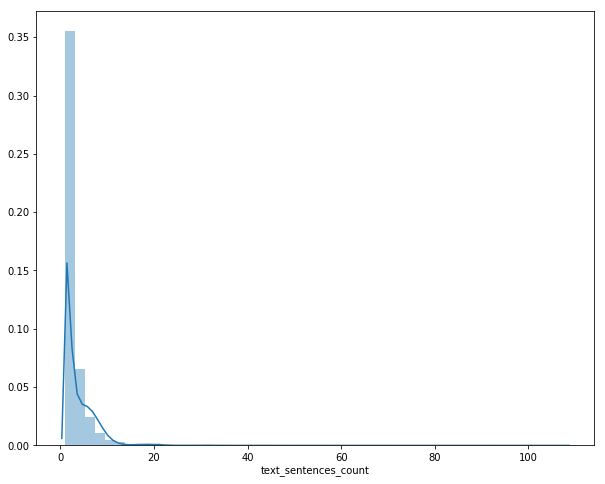

In [347]:
plt.figure(figsize=(10,8))
sns.distplot(fin_df[fin_df['text_sentences_count']>0]['text_sentences_count'])

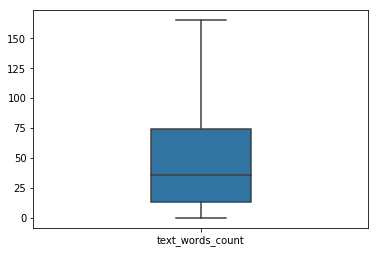

In [77]:
sns.boxplot(data=fin_df[['text_words_count']], orient='v', showfliers=False, width=0.3)

в заголовках до 20 слов, в основном 10

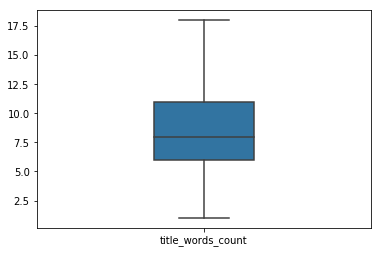

In [76]:
sns.boxplot(data=fin_df[fin_df['title_words_count'] > 0][['title_words_count']], orient='v', 
            showfliers=False, width=0.3)

### в заголовках слова используются чуть длиннее, чем в текстах
это мб связано с тем, что не почищены стоп слова или с тем, что тексты написаны простым языком, а заголовки "умным" 

In [ ]:
%%time # не дождалась! плохой способ, тк каждый раз аллоцируется память для нового списка => n переаллокаций

lengths_of_text_words = reduce(lambda x, y: x + y, fin_df['lengths_of_text_words'].values)

In [102]:
%%time 
# < 1 сек! начинается аллокация с 8 элементами, как только не влезает, то переаллоцируется на 12 элементов, 
# потом 20, 100, 200, 500 и тд => log(n) переаллокаций

text_word_lens = []
for ws in fin_df['lengths_of_text_words'].values:
    text_word_lens += ws
    
title_word_lens = []
for ws in fin_df['lengths_of_title_words'].values:
    title_word_lens += ws

CPU times: user 95.3 ms, sys: 36.5 ms, total: 132 ms
Wall time: 131 ms


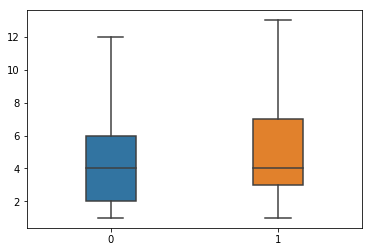

In [105]:
sns.boxplot(data=[text_word_lens, title_word_lens], orient='v', 
            showfliers=False, width=0.3)

### предложение считать популярными посты, у которых скор > (mean + std)
в данном случае 13 + 59 = 72


In [214]:
print('null score \t{}%'.format(fin_df[(fin_df['type']=='story')].score.isnull().mean() * 100))
print('mean score \t{}'.format(fin_df[(fin_df['type']=='story')].score.mean() ))
print('std \t\t{}'.format(fin_df[(fin_df['type']=='story')].score.std() ))

null score 	3.344316817048009%
mean score 	13.361997005129512
std 		59.22087463294035


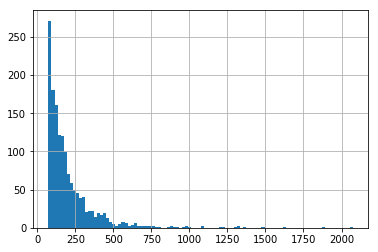

In [309]:
fin_df[(fin_df['type']=='story') & (fin_df['score'] > 72)].score.fillna(-0.5).hist(bins=100)

### топ хостов в мае 2018

In [190]:
fin_df['netloc'] = fin_df['url'].fillna('').apply(lambda x: urllib.parse.urlparse(x).netloc)

In [220]:
fin_df['netloc'].value_counts().reset_index(name='posts_count').head(10)

,index,posts_count
0,,208110
1,medium.com,1583
2,github.com,1143
3,www.youtube.com,670
4,www.nytimes.com,414
5,prepareforjob.in,383
6,techcrunch.com,337
7,www.theguardian.com,313
8,www.bloomberg.com,309
9,arstechnica.com,262


### топ авторов в мае 2018

In [225]:
fin_df[fin_df['type']=='story']['by'].value_counts().reset_index(name='posts_count').head(10)

,index,posts_count
0,rbanffy,668
1,raleighm,323
2,tosh,229
3,godelmachine,199
4,jonbaer,197
5,ingve,179
6,dsr12,150
7,dulo,149
8,john58,143
9,Tomte,137


лидеры публиковали более 10 постов в день

это нормальное число вообще???

### топ комментаторов в мае 2018

In [226]:
fin_df[fin_df['type']=='comment']['by'].value_counts().reset_index(name='posts_count').head(10)

,index,posts_count
0,jacquesm,786
1,icebraining,547
2,dragonwriter,546
3,pjmlp,428
4,dang,425
5,gowld,423
6,s73v3r_,419
7,TeMPOraL,405
8,scarface74,401
9,tptacek,351


### статистики по деревьям: 
* степень вершин (количество комментариев), 
* глубина (длинна цепочки связей), 
* кол-во всех детей и детей детей (количетсво всех коментариев внизу)

### количество комментариев у стори: в 80% случаев комментариев нет
в остальных 20: 1-2 комментрия, но возможно это из-за малого количества времени, которе посты полежали на сайте

In [156]:
fin_df = pd.merge(fin_df, fin_df['parent'].value_counts().reset_index(name='kids_count'),
         left_on='id', right_on='index', how='left')
fin_df['kids_count'].fillna(0, inplace=True)

In [189]:
fin_df[(fin_df['type']=='story')&(fin_df['kids_count']==0)].shape[0] / fin_df[(fin_df['type']=='story')].shape[0]

0.8004188094724848

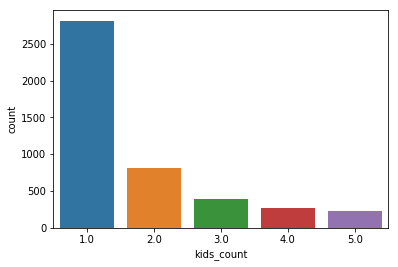

In [316]:
sns.countplot(fin_df[(fin_df['type']=='story')&(fin_df['kids_count'] > 0)&(fin_df['kids_count'] <= 5)]\
    ['kids_count'])

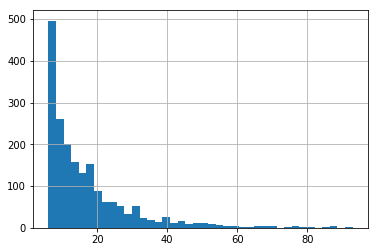

In [314]:
fin_df[(fin_df['type']=='story')&(fin_df['kids_count'] > 5)&(fin_df['kids_count'] < 100)]['kids_count'].hist(bins=40)

### длины цепочек

In [283]:
tree = {}

for node_id, node_children_list in fin_df.loc[:, ['id', 'kids']].values:
    if node_children_list is None:
        node_children_list = []
    tree[node_id] = list(node_children_list)

In [296]:
@lru_cache(maxsize=None)
def height(node):
    if node not in tree or not tree[node]:
        return 0
    
    return 1 + max(map(height, tree[node]))

heights = {node: height(node) for node in tree}

In [318]:
@lru_cache(maxsize=None)
def count_all_commemts(node):
    if node not in tree or not tree[node]:
        return 0
    
    return len(tree[node]) + sum(map(count_all_commemts, tree[node]))

commemts_count = {node: count_all_commemts(node) for node in tree}

In [299]:
fin_df['height'] = fin_df['id'].map(heights)
fin_df['commemts_count'] = fin_df['id'].map(commemts_count)

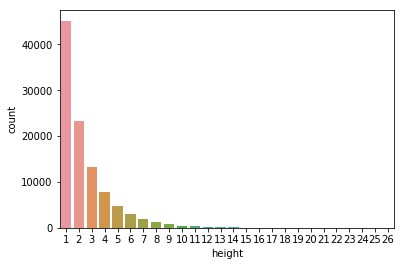

In [304]:
sns.countplot(fin_df[fin_df['height']>0]['height'])

### суммарное количество всех комментов под стори

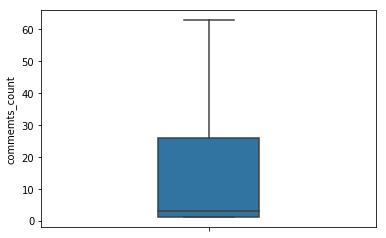

In [335]:
sns.boxplot(fin_df[(fin_df['commemts_count']>0)&(fin_df['type']=='story')]['commemts_count'], showfliers=False, orient='v', width=0.3)